0.00006 0.61
/n
0.00004
train Loss: 1.1345 Acc: 0.7697
val Loss: 1.2567 Acc: 0.6433
Training complete in 15m 20s
Best val Acc: 0.754386
/n
drop 0.3 0.000035
train Loss: 1.0468 Acc: 0.8571
val Loss: 1.1915 Acc: 0.7135
Training complete in 15m 21s
Best val Acc: 0.771930
/n
drop 0.2 0.000035
train Loss: 1.0076 Acc: 0.8976
val Loss: 1.1832 Acc: 0.7193
Training complete in 15m 22s
Best val Acc: 0.824561

0.000033
train Loss: 0.9895 Acc: 0.9146
val Loss: 1.1530 Acc: 0.7514
Training complete in 16m 2s
Best val Acc: 0.751412

0.000034
train Loss: 1.0346 Acc: 0.8700
val Loss: 1.2208 Acc: 0.6836
Training complete in 16m 1s
Best val Acc: 0.774011

0.000035
train Loss: 1.0473 Acc: 0.8575
val Loss: 1.1514 Acc: 0.7512
Training complete in 18m 8s
Best val Acc: 0.840796

In [ ]:
##Please first install the following packgage in ur local environment:
# pip install tensorflow-gpu, opencv-python, numpy, Pillow, scipy
#Mount ur google drive, there will be a url for an authorization code
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#Upload the Dataset to ur google drive and unzip it.
!nohup unzip /gdrive/'My Drive'/ArashiProject/face_data.zip      
!ls

nohup: ignoring input and appending output to 'nohup.out'
face_data  __MACOSX  nohup.out	sample_data


In [ ]:
# Please install below:
# !conda install pytorch torchvision torchaudio -c pytorch -c conda-forge
# pip install matplotlib

In [ ]:
# Import libraries
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
import cv2
from matplotlib import pyplot as plt

In [ ]:
# Parameters
batch_size = 16
vali_split = 0.9
learning_rate = 0.000035
epochs = 120
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# First method, the most general one
class MyVGG(torch.nn.Module):
  # put your models here
  def __init__(self):
    super().__init__()
    self.vgg19_features = models.vgg19(pretrained=False).features
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(512, 512)
    self.relu = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout(p=0.2)
    self.fc2 = torch.nn.Linear(512, 256)
    self.relu = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout(p=0.2)
    self.fc3 = torch.nn.Linear(256, 5)
    self.softmax = torch.nn.Softmax(dim=1)
    
  # define inference
  def forward(self,x):
    x = self.vgg19_features(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc3(x)
    x = self.softmax(x)

    return x

In [ ]:
# Transform is used to preprocess your raw image data and convert to tensors
transform_dict = {
        'train': transforms.Compose(
            [transforms.Resize((32,32)),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ]),
        'test': transforms.Compose(
            [transforms.Resize((32,32)),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])}
# loading images using datasets function
# This will automatically label the subdirectories! 
dataset = torchvision.datasets.ImageFolder(root='face_data', transform=transform_dict['train'])
# Split the datasets for training and validation
# traing_size + val_size should equal the number of the total images
train_size = (int) (len(dataset) * vali_split)
val_size = len(dataset) - train_size
dataset_sizes = {'train': train_size, 'val': val_size}
dataset_train, dataset_val = torch.utils.data.random_split(dataset, [train_size, val_size])
# create dataloader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(dataset_val,   batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

In [ ]:
def showdata(img,x,y):   
    npimg = img.numpy()
    resizeimg= npimg.repeat(5, axis=1).repeat(5, axis=2)
    plt.figure(figsize=(x,y))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


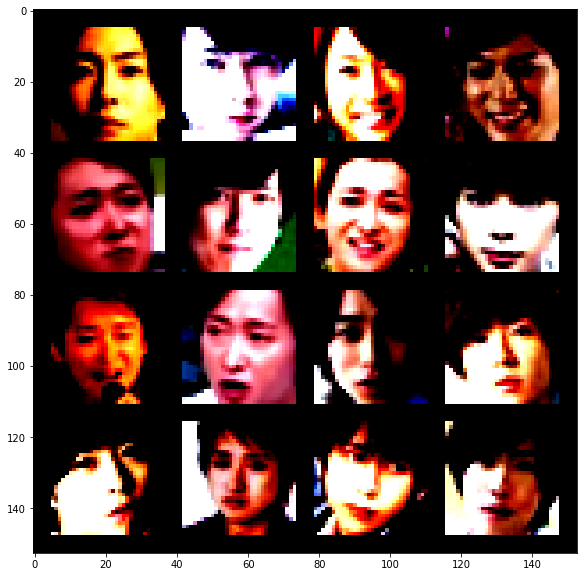

tensor([0, 4, 0, 1, 3, 2, 3, 1, 3, 3, 4, 0, 4, 3, 2, 0])


In [ ]:
dataiter = iter(dataloaders["train"])
images, labels = dataiter.next()
showdata(torchvision.utils.make_grid(images,nrow=int(np.sqrt(batch_size)), padding=5),10,10)
print(labels)

In [ ]:
# Training algorithm
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('best model saved')


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = MyVGG().to(device)
# Set loss function
criterion = torch.nn.CrossEntropyLoss()
# Set optimizer 
optimizer_ft = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-9)
best_model = train_model(model, criterion, optimizer_ft, num_epochs=epochs)

Epoch 0/119
----------
train Loss: 1.5961 Acc: 0.2435
val Loss: 1.5754 Acc: 0.3582
best model saved
Epoch 1/119
----------
train Loss: 1.5343 Acc: 0.3688
val Loss: 1.4761 Acc: 0.4179
best model saved
Epoch 2/119
----------
train Loss: 1.4859 Acc: 0.4038
val Loss: 1.4537 Acc: 0.4378
best model saved
Epoch 3/119
----------
train Loss: 1.4592 Acc: 0.4332
val Loss: 1.4483 Acc: 0.4279
Epoch 4/119
----------
train Loss: 1.4410 Acc: 0.4515
val Loss: 1.4412 Acc: 0.4527
best model saved
Epoch 5/119
----------
train Loss: 1.4209 Acc: 0.4748
val Loss: 1.4317 Acc: 0.4726
best model saved
Epoch 6/119
----------
train Loss: 1.4180 Acc: 0.4731
val Loss: 1.4059 Acc: 0.4826
best model saved
Epoch 7/119
----------
train Loss: 1.4074 Acc: 0.4847
val Loss: 1.4234 Acc: 0.4677
Epoch 8/119
----------
train Loss: 1.3721 Acc: 0.5236
val Loss: 1.4164 Acc: 0.4726
Epoch 9/119
----------
train Loss: 1.3723 Acc: 0.5247
val Loss: 1.4064 Acc: 0.4876
best model saved
Epoch 10/119
----------
train Loss: 1.3907 Acc: 0.5

In [ ]:
# Save the model
torch.save(model, 'Arashi_model.h5')
#torch.save(model.to('cpu').state_dict(), "Arashi_model.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform_data = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.Resize((32,32)),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


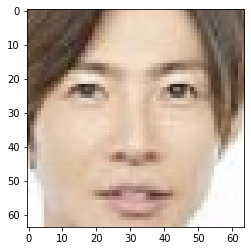

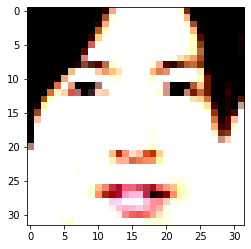

[100   0   0   0   0]
[0 4 1 2 3]
Aiba


In [44]:
# How to load and test model
import torch

# Input   ここを自分の画像で実装してください。
#inp = torch.from_numpy(np.random.rand(1, 3, 32, 32)).float()
img = cv2.imread('/content/drive/My Drive//ArashiProject/test_Aiba.png')
clr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(clr)
inp = transform_data(clr)
showdata(torchvision.utils.make_grid(inp,nrow=1, padding=5),4,4)
inp = inp.unsqueeze(0)

# Load model
loaded_model = torch.load('Arashi_model.h5', map_location=torch.device('cpu')) # for cpu

# Predict
output = loaded_model(inp)
_,predicted = torch.max(output, 1)
output = output.to('cpu').detach().numpy()
output = output[0]
rank = np.argsort(output)
output = (np.sort(output))*100
output = output[::-1]
output = np.asarray(output, dtype = int)
rank = rank[::-1]

print(output)
print(rank)

# Output ここを犬か猫か判別してください。
if(predicted==0): print('Aiba')
elif(predicted==1): print('Matsumoto')
elif(predicted==2): print('Ninomiya')
elif(predicted==3): print('Ohno')
else: print('Sakurai')

Image number: 2004
Image list make done.
(64, 64)
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

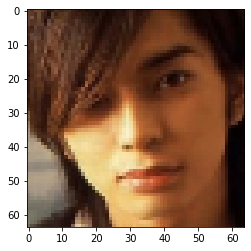

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
import numpy as np

imgs = []
index = []
for file in glob.glob('/content/drive/My Drive//ArashiProject/dataget/face_data/Aiba_face/*'):
  imgs.append(file)
  index.append(2)
for file in glob.glob('/content/drive/My Drive//ArashiProject/dataget/face_data/Sakurai_face/*'):
  imgs.append(file)
  index.append(0)
for file in glob.glob('/content/drive/My Drive//ArashiProject/dataget/face_data/Ohno_face/*'):
  imgs.append(file)
  index.append(3)
for file in glob.glob('/content/drive/My Drive//ArashiProject/dataget/face_data/Ninomiya_face/*'):
  imgs.append(file)
  index.append(1)
for file in glob.glob('/content/drive/My Drive//ArashiProject/dataget/face_data/Matsumoto_face/*'):
  imgs.append(file)
  index.append(4)
 
print("Image number:", len(imgs))
print("Image list make done.")

for i in imgs[::124]:
  img = Image.open(i)
print(img.size)
print(index)
plt.figure()
plt.imshow(np.asarray(img))

In [46]:
def img_to_matrix(img):
  img_array = np.asarray(img)
  return img_array
 
def flatten_img(img_array):
  s = img_array.shape[0] * img_array.shape[1] * img_array.shape[2]
  img_width = img_array.reshape(1, s)
  return img_width[0]

In [47]:
dataset = []
for i in imgs:
  img = Image.open(i)
  img = img_to_matrix(img)
  img = flatten_img(img)
  dataset.append(img)

dataset = np.array(dataset)
index = np.array(index)
print(dataset.shape)

(2004, 12288)


第1主成分: [0.01 0.01 0.01 ... 0.01 0.01 0.01]
第2主成分: [-0.   -0.   -0.   ... -0.01 -0.01 -0.01]


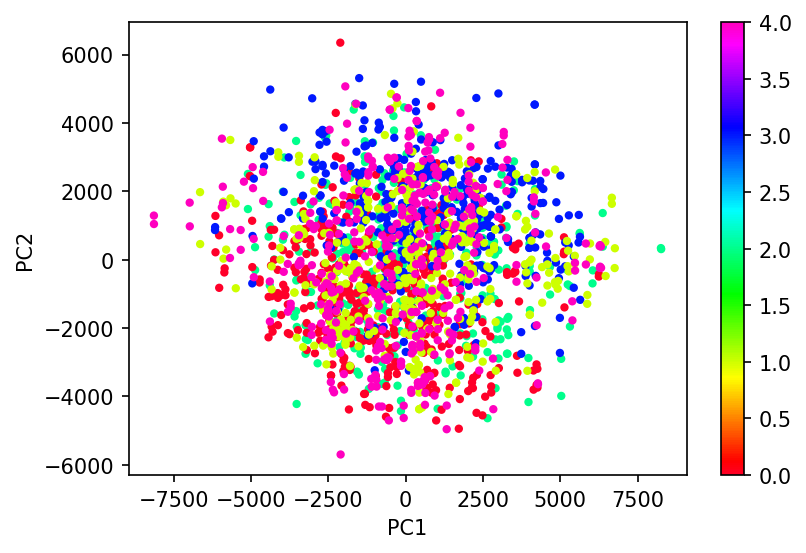

In [48]:
pca = PCA(n_components = 5)
P = pca.fit_transform(dataset)

#第一主成分と第二主成分のベクトル
print("第1主成分:", pca.components_[0])
print("第2主成分:", pca.components_[1])

plt.figure(dpi=150)
clrs = ["green", "red", "blue", "yellow", "purple"]
m = plt.scatter(P[:, 0], P[:, 1], c=index, marker='.', cmap='gist_rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(m)
plt.show()

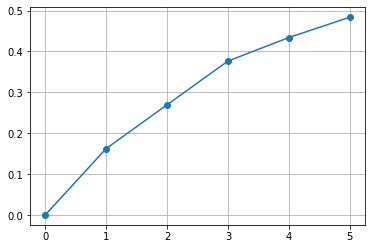

In [49]:
import matplotlib.ticker as ticker
#累積寄与率のグラフ
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list(np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.grid()
plt.show()